#### Read Data

In [1]:
import sframe
products = sframe.SFrame('data1/')

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1503134538.log


#### Clean data

In [2]:
def remove_punctuation(text):
    import string
    return text.translate(None,string.punctuation)

products['review_clean'] = products['review'].apply(remove_punctuation)

products = products[products['rating']!=3]
products['sentiment'] = products['rating'].apply(lambda rating: +1 if rating > 3 else -1)


#### Split into training set and test sets

In [3]:
train_data,test_data = products.random_split(.8,seed=1)

#### Bag of words model

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

train_matrix = vectorizer.fit_transform(train_data['review_clean'])
test_matrix = vectorizer.transform(test_data['review_clean'])

#### Use Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_matrix,train_data['sentiment'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Accuracy

In [6]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_data['sentiment'].to_numpy(),model.predict(test_matrix))

print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932265418766


#### Majority Class Classifier

In [8]:
baseline = len(test_data[test_data['sentiment'] == 1]) / float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" %baseline

Baseline accuracy (majority class classifier): 0.842782577394


#### Confusion Matirx

In [9]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   805
      1       |        1        | 27290


#### Precision and Recall

In [12]:
from sklearn.metrics import precision_score

precision = precision_score(test_data['sentiment'].to_numpy(),model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949448561389


In [15]:
from sklearn.metrics import recall_score
recall = recall_score(test_data['sentiment'].to_numpy(),model.predict(test_matrix))
print "REcall on test data: %s" %recall

REcall on test data: 0.971347214807


#### Change prediction threshold

In [45]:
def apply_threshold(prob,thre):
    
    return sframe.SArray(prob).apply(lambda pro: +1 if pro > thre else -1).to_numpy()

probabilities = model.predict_proba(test_matrix)[:,1]
predictions_point_5 = apply_threshold(probabilities,0.5)
len(predictions_point_5)
model.predict(test_matrix)

array([1, 1, 1, ..., 1, 1, 1])

In [52]:
precision_score(np.array(test_data['sentiment']),predictions_point_5)

0.94944856138885991

In [35]:
predictions_point_9 = apply_threshold(probabilities,0.9)
predictions_point_9

array([-1,  1,  1, ...,  1,  1,  1])

#### Precision-recall Curve

In [53]:
import numpy as np
threshold_values = np.linspace(0.5,1,num = 100)
precision_all = []
recall_all = []
for thre in threshold_values:
    precision_all.append(precision_score(list(test_data['sentiment']),apply_threshold(model.predict_proba(test_matrix)[:,1],thre)))
    recall_all.append(recall_score(list(test_data['sentiment']),apply_threshold(model.predict_proba(test_matrix)[:,1],thre)))
precision_all

/Users/ziaochen/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.94944856138885991,
 0.9499233876584483,
 0.95040083652840712,
 0.95091232599518538,
 0.95133361262393523,
 0.95177860088056465,
 0.95202629462568622,
 0.95227598754417275,
 0.95288966725043778,
 0.9532087904384704,
 0.95355526712737226,
 0.95386559932588999,
 0.95422609428792249,
 0.95444479595064857,
 0.95489092188599578,
 0.95513294594118681,
 0.95554066918168035,
 0.9559586406465046,
 0.9562345460967856,
 0.95648639095086607,
 0.9570371943235304,
 0.95731793709266078,
 0.95770403460256681,
 0.95793132803632242,
 0.95821796237131696,
 0.95874200426439238,
 0.95912777461582244,
 0.95964956016952174,
 0.96010552960889872,
 0.96066393003747996,
 0.96105334619644833,
 0.96140639530724659,
 0.96196683737420763,
 0.96221409622140963,
 0.96271441900523935,
 0.96296429341188305,
 0.96328658755843222,
 0.96390749945969312,
 0.96422259891080897,
 0.96466086705410969,
 0.96479560487223048,
 0.96508304085103302,
 0.96546976339722457,
 0.96563860667634249,
 0.96603581677503725,
 0.966286005237

In [59]:
recall_all

[0.97134721480690511,
 0.97092009254315714,
 0.97052856380138819,
 0.97013703505961912,
 0.96992347392774514,
 0.96949635166399717,
 0.9691048229222281,
 0.96874888770243817,
 0.9683217654386902,
 0.96800142374087916,
 0.96753870795515218,
 0.96700480512546716,
 0.96682683751557219,
 0.96647090229578214,
 0.96593699946609712,
 0.96533190959245418,
 0.96465563267485321,
 0.96419291688912623,
 0.96355223349350416,
 0.96312511122975619,
 0.96255561487809216,
 0.96198611852642824,
 0.96148780921872223,
 0.96123865456486923,
 0.96077593877914225,
 0.96027762947143624,
 0.95970813311977221,
 0.95910304324612916,
 0.95853354689446524,
 0.95792845702082219,
 0.95735896066915827,
 0.9567182772735362,
 0.95607759387791424,
 0.95533012991635524,
 0.95486741413062826,
 0.95415554369104827,
 0.9535148602954262,
 0.95248264815803518,
 0.95159281010856023,
 0.95120128136679127,
 0.95009788218544222,
 0.94935041822388322,
 0.94842498665242925,
 0.94725040042712227,
 0.9465741235095213,
 0.945684285460

In [60]:
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

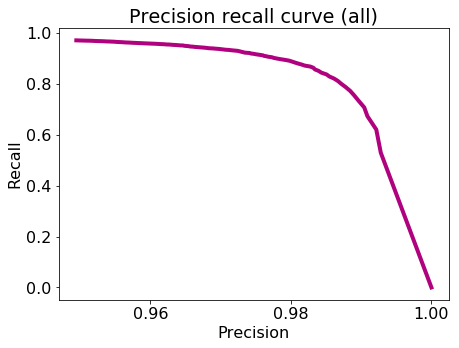

In [62]:
import matplotlib.pyplot as plt
precision_all[len(precision_all)-1] = 1
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')
plt.show()